In [16]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier

# Load Datasets

## Load Train Data

In [17]:
df_train = pd.read_csv('Datasets/train.csv')
df_train

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


In [18]:
df_train.drop('id',inplace=True,axis=1)

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  naso

## Load Test Data

In [20]:
df_test = pd.read_csv('Datasets/test.csv')
df_test

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,no,adult,529461,40.3,114.0,36.0,cool,reduced,normal_pink,...,distend_large,57.0,8.1,serosanguious,4.5,yes,3205,0,0,yes
820,2055,yes,adult,535338,37.2,100.0,20.0,cool,reduced,pale_cyanotic,...,distend_small,50.0,66.0,serosanguious,2.0,yes,2209,0,0,no
821,2056,yes,adult,529640,39.2,132.0,12.0,cool,reduced,dark_cyanotic,...,NaN,53.0,7.6,serosanguious,4.5,yes,2205,0,0,no
822,2057,no,adult,5287179,38.3,54.0,66.0,normal,normal,normal_pink,...,NaN,49.0,8.6,clear,5.0,no,3111,0,0,yes


In [21]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     824 non-null    int64  
 1   surgery                824 non-null    object 
 2   age                    824 non-null    object 
 3   hospital_number        824 non-null    int64  
 4   rectal_temp            824 non-null    float64
 5   pulse                  824 non-null    float64
 6   respiratory_rate       824 non-null    float64
 7   temp_of_extremities    789 non-null    object 
 8   peripheral_pulse       777 non-null    object 
 9   mucous_membrane        811 non-null    object 
 10  capillary_refill_time  818 non-null    object 
 11  pain                   795 non-null    object 
 12  peristalsis            805 non-null    object 
 13  abdominal_distention   802 non-null    object 
 14  nasogastric_tube       760 non-null    object 
 15  nasoga

# Exploratory Data Analysis (EDA)

In [22]:
df_train.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


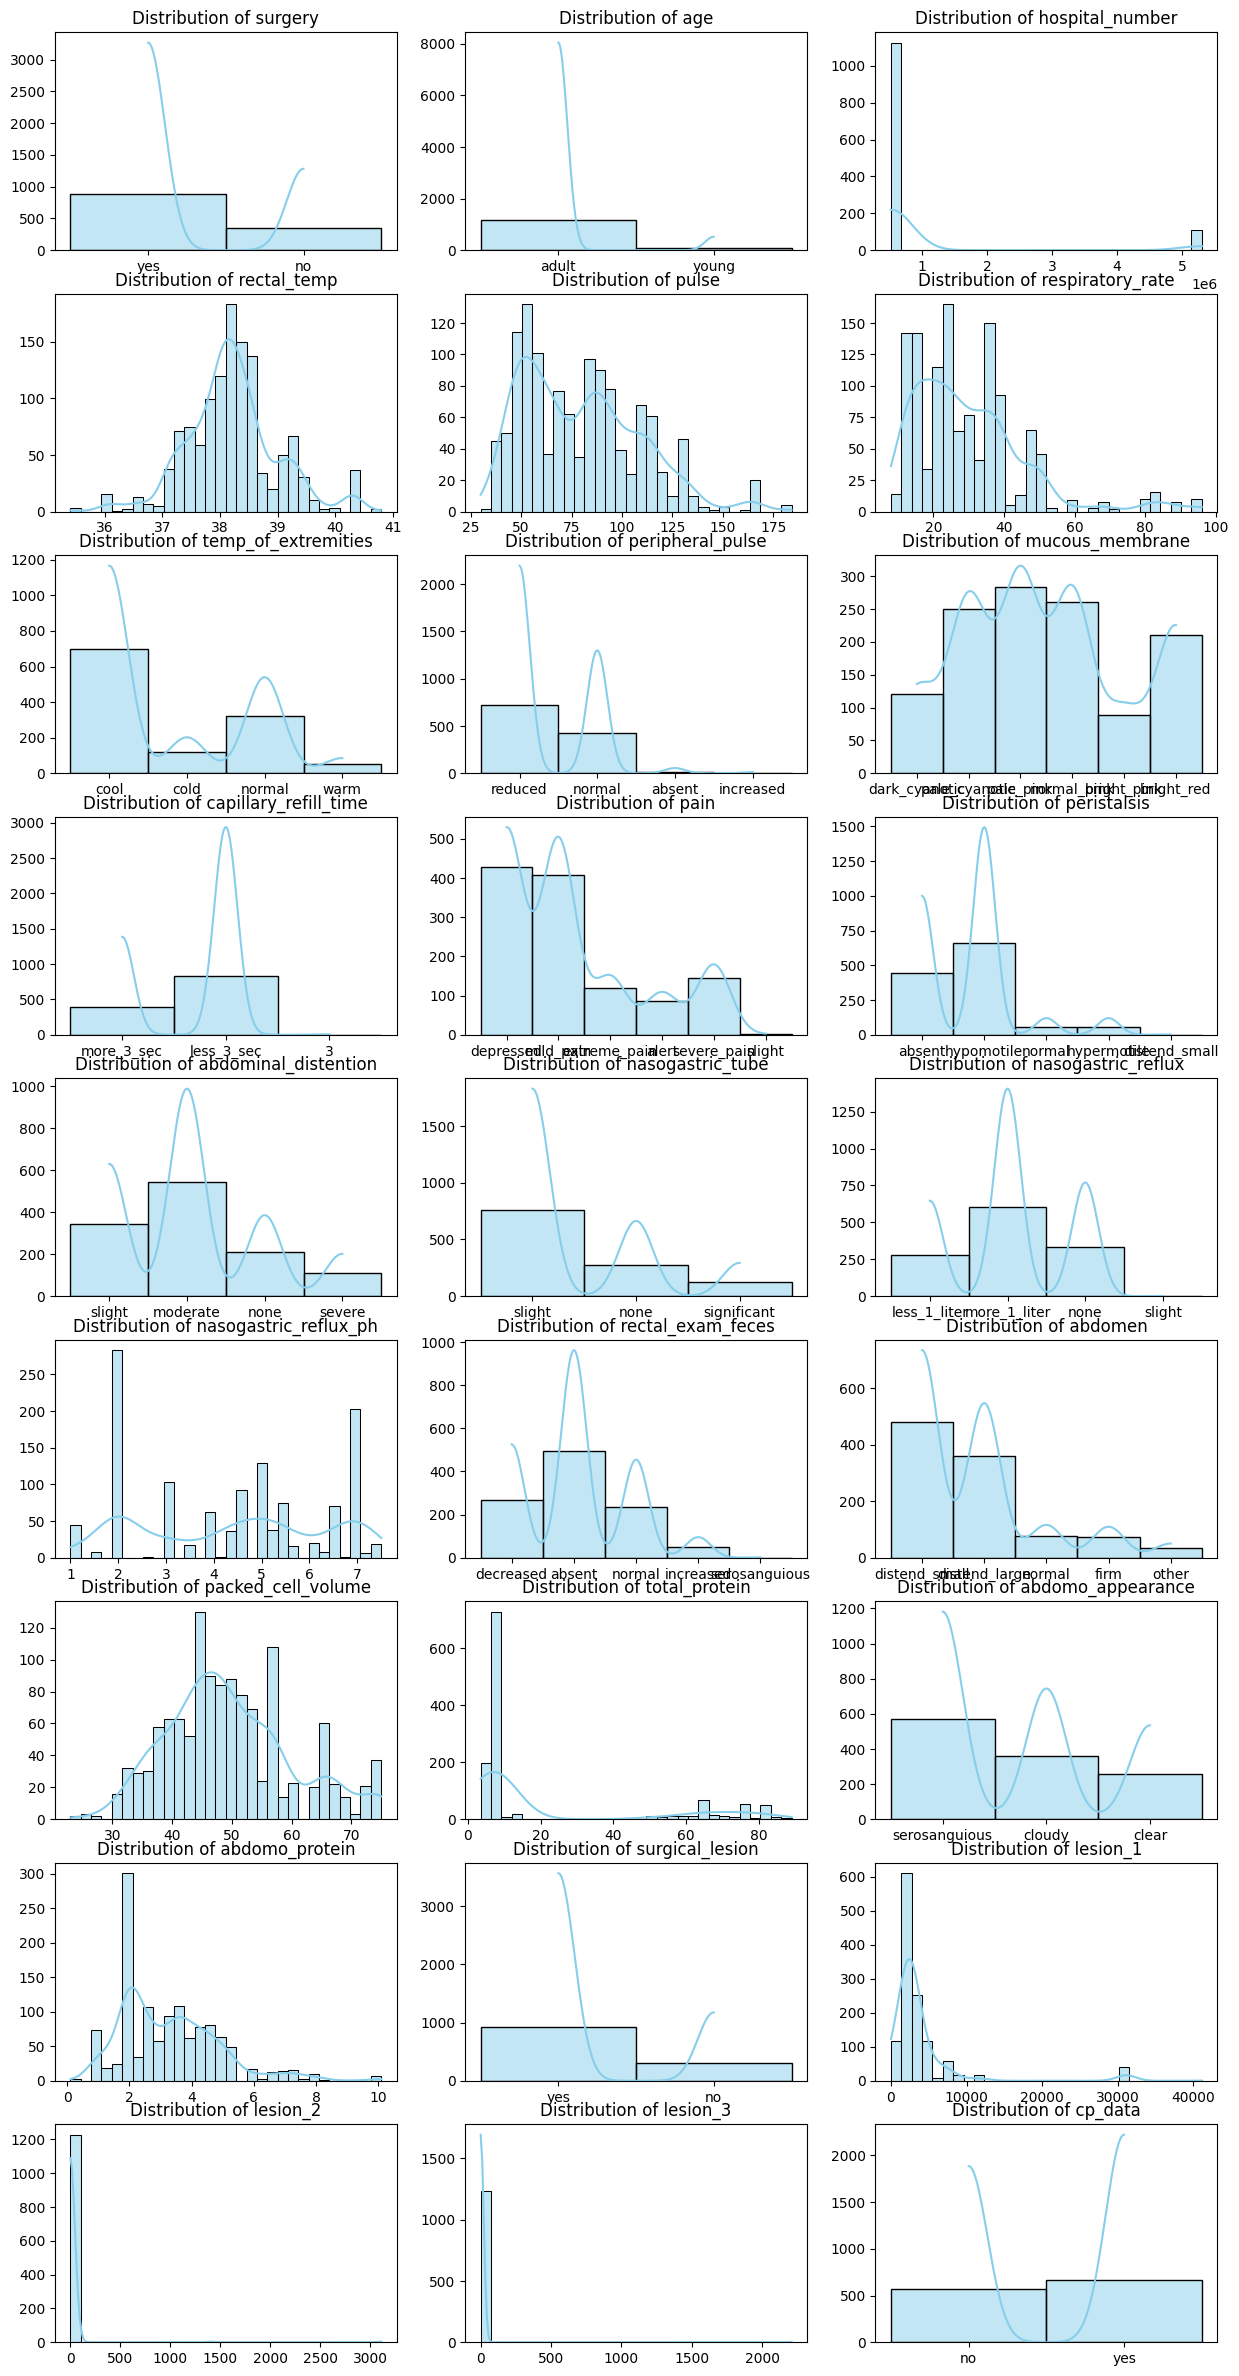

In [23]:
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(df_train.columns[:-1], axes)):
    sns.histplot(df_train[col], ax=ax, kde=True, color='skyblue', bins=30)
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

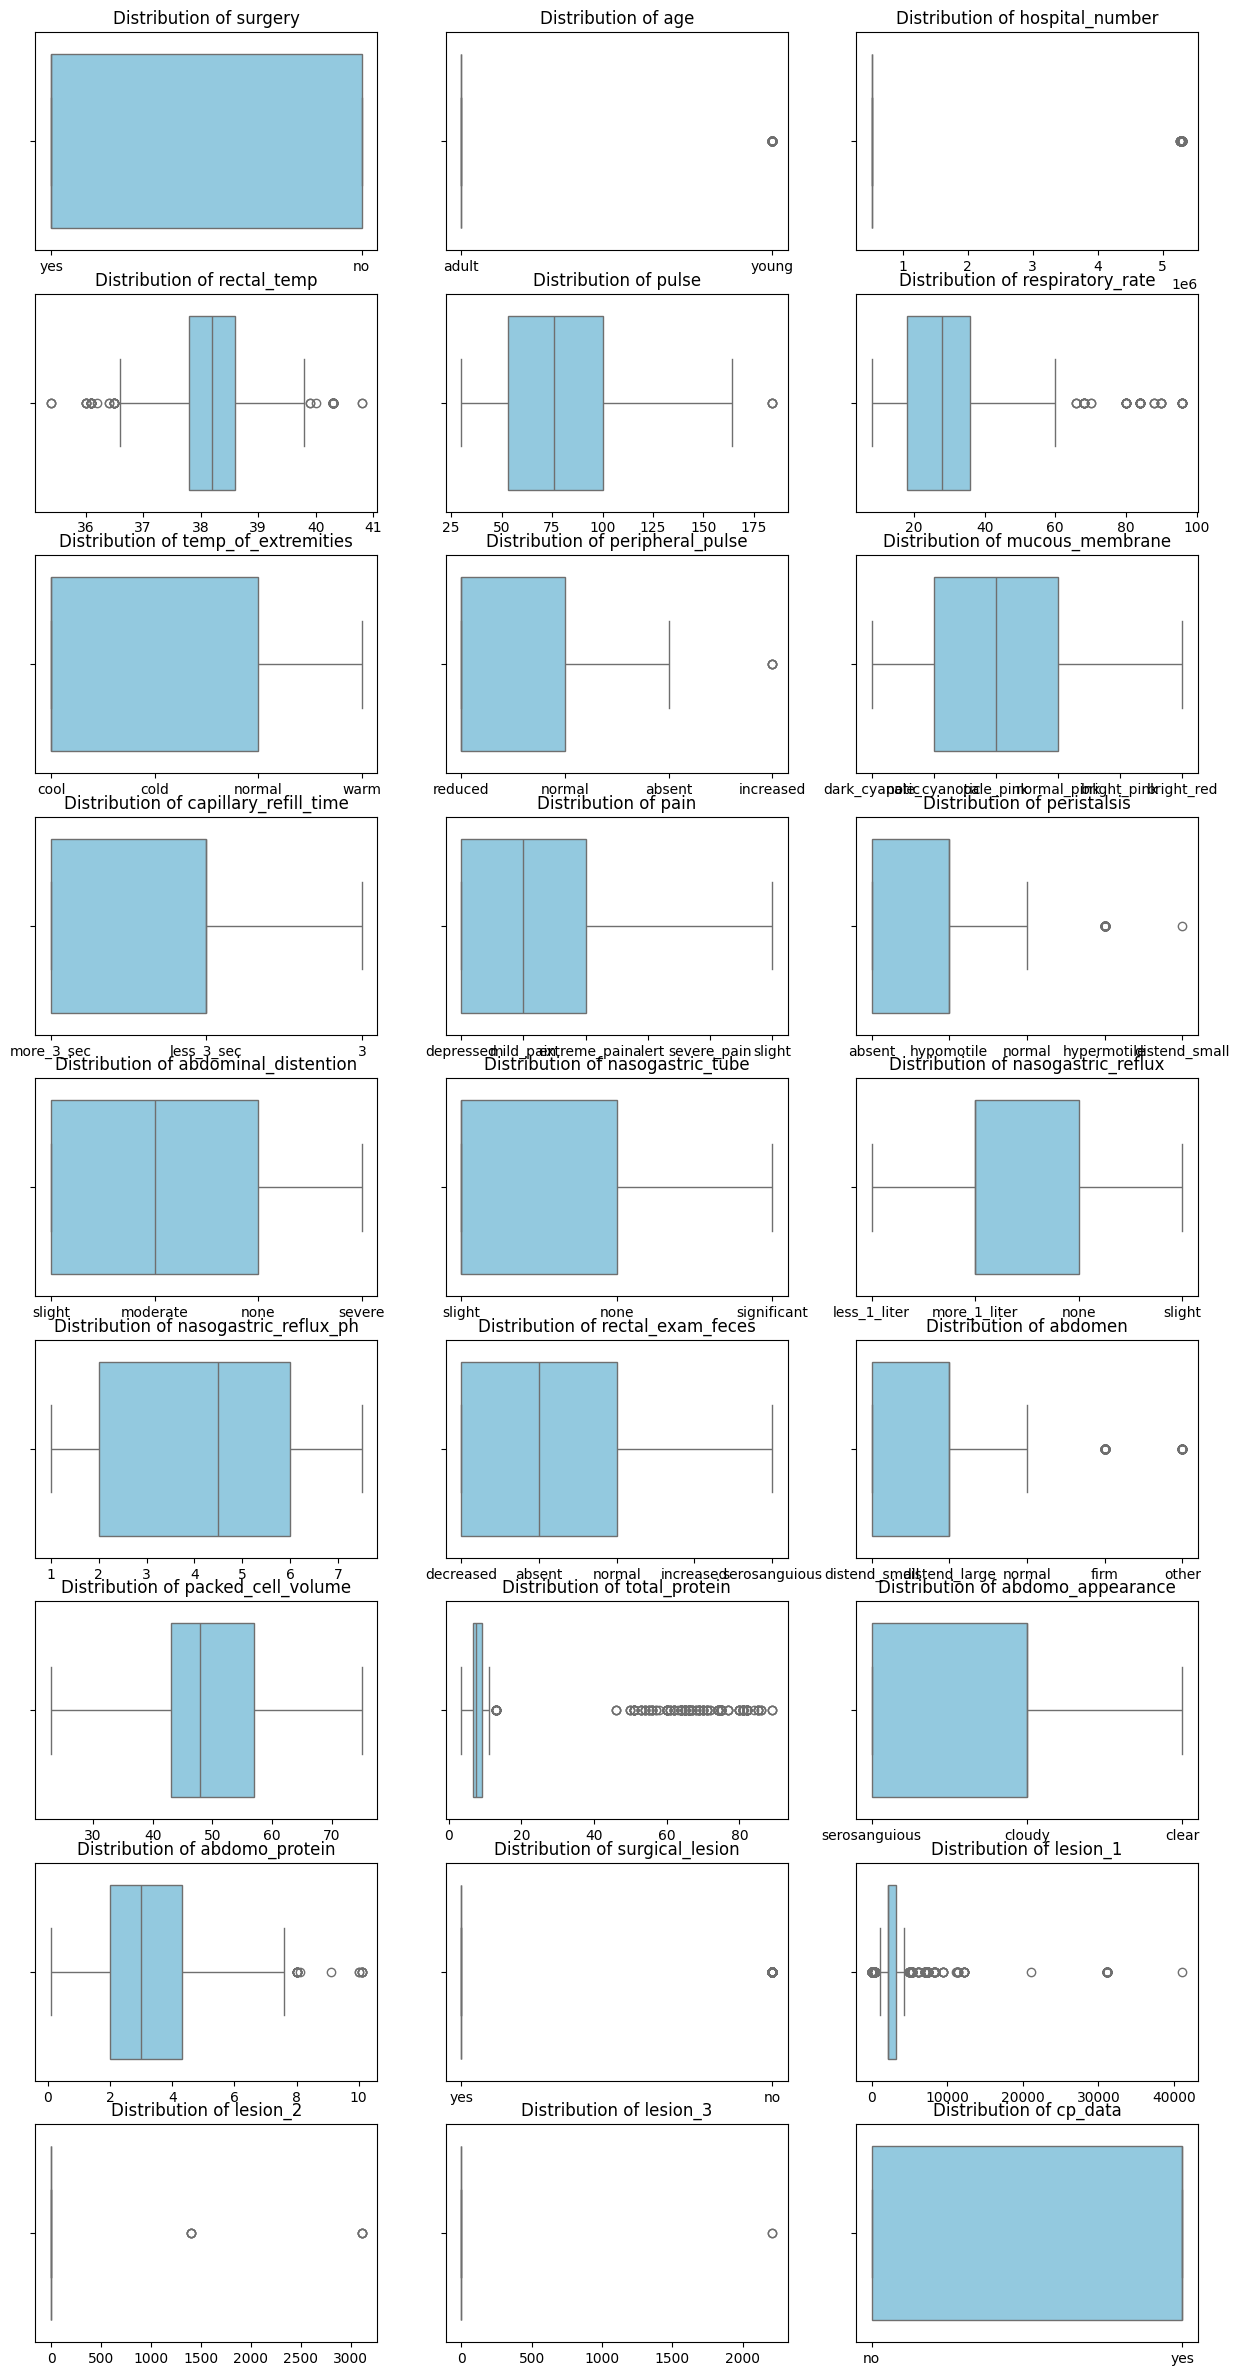

In [24]:
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(df_train.columns[:-1], axes)):
    sns.boxplot(x=df_train[col],ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Data Preprocessing

- ## Handle Missing Value

In [25]:
def handle_missing_value(df: pd.DataFrame):
    for i in df.columns:
        if pd.api.types.is_numeric_dtype(df[i].dtype):
            df[i].fillna(df[i].mean(),inplace=True)
        else:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [26]:
handle_missing_value(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1235 non-null   object 
 7   peripheral_pulse       1235 non-null   object 
 8   mucous_membrane        1235 non-null   object 
 9   capillary_refill_time  1235 non-null   object 
 10  pain                   1235 non-null   object 
 11  peristalsis            1235 non-null   object 
 12  abdominal_distention   1235 non-null   object 
 13  nasogastric_tube       1235 non-null   object 
 14  nasogastric_reflux     1235 non-null   object 
 15  naso

In [27]:
handle_missing_value(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     824 non-null    int64  
 1   surgery                824 non-null    object 
 2   age                    824 non-null    object 
 3   hospital_number        824 non-null    int64  
 4   rectal_temp            824 non-null    float64
 5   pulse                  824 non-null    float64
 6   respiratory_rate       824 non-null    float64
 7   temp_of_extremities    824 non-null    object 
 8   peripheral_pulse       824 non-null    object 
 9   mucous_membrane        824 non-null    object 
 10  capillary_refill_time  824 non-null    object 
 11  pain                   824 non-null    object 
 12  peristalsis            824 non-null    object 
 13  abdominal_distention   824 non-null    object 
 14  nasogastric_tube       824 non-null    object 
 15  nasoga

- ## Label Encoding

In [28]:
# Encode Binary Data
df_train['surgery'].replace({'yes':1,'no':0},inplace=True)
df_train['age'].replace({'adult':1,'young':0},inplace=True)
df_train['surgical_lesion'].replace({'yes':1,'no':0},inplace=True)
df_train['cp_data'].replace({'yes':1,'no':0},inplace=True)
df_test['surgery'].replace({'yes':1,'no':0},inplace=True)
df_test['age'].replace({'adult':1,'young':0},inplace=True)
df_test['surgical_lesion'].replace({'yes':1,'no':0},inplace=True)
df_test['cp_data'].replace({'yes':1,'no':0},inplace=True)

# Encode Ordinal Data
df_train['temp_of_extremities'].replace({'cold':3,'cool':2,'normal':1,'warm':0},inplace=True)
df_train['peripheral_pulse'].replace({'reduced':3,'normal':2,'absent':1,'increased':0},inplace=True)
df_train['capillary_refill_time'].replace({'less_3_sec':1,'more_3_sec':2,'3':0},inplace=True)
df_train['pain'].replace({'extreme_pain': 4, 'severe_pain': 3, 'moderate': 2, 'depressed': 1, 'mild_pain': 1, 'slight': 0, 'alert': 0}, inplace=True)
df_train['peristalsis'].replace({'absent': 0, 'distend_small': 1, 'hypomotile': 2, 'normal': 3, 'hypermotile': 4}, inplace=True)
df_train['abdominal_distention'].replace({'none':0,'slight':1,'moderate':2,'severe':3},inplace=True)
df_train['nasogastric_tube'].replace({'none':0,'slight':1,'significant':2},inplace=True)
df_train['nasogastric_reflux'].replace({'none':0,'slight':1,'less_1_liter':2,'more_1_liter':3},inplace=True)
df_train['rectal_exam_feces'].replace({'absent':0,'decreased':1,'normal':2,'increased':3,'serosanguious':3},inplace=True)
df_train['abdomen'].replace({'normal':0,'firm':1,'distend_small':2,'distend_large':3,'other':0},inplace=True)
df_train['abdomo_appearance'].replace({'clear':0,'cloudy':1,'serosanguious':2},inplace=True)
df_train['mucous_membrane'].replace({'normal_pink':0,'bright_pink':1,'pale_pink':2,'pale_cyanotic':3,'bright_red':4,'dark_cyanotic':5},inplace=True)

df_train['outcome'].replace({'died':0, 'euthanized':1, 'lived':2},inplace=True)

df_test['temp_of_extremities'].replace({'cold':3,'cool':2,'normal':1,'warm':0},inplace=True)
df_test['peripheral_pulse'].replace({'reduced':3,'normal':2,'absent':1,'increased':0},inplace=True)
df_test['capillary_refill_time'].replace({'less_3_sec':1,'more_3_sec':2,'3':0},inplace=True)
df_test['pain'].replace({'extreme_pain': 4, 'severe_pain': 3, 'moderate': 2, 'depressed': 1, 'mild_pain': 1, 'slight': 0, 'alert': 0}, inplace=True)
df_test['peristalsis'].replace({'absent': 0, 'distend_small': 1, 'hypomotile': 2, 'normal': 3, 'hypermotile': 4}, inplace=True)
df_test['abdominal_distention'].replace({'none':0,'slight':1,'moderate':2,'severe':3},inplace=True)
df_test['nasogastric_tube'].replace({'none':0,'slight':1,'significant':2},inplace=True)
df_test['nasogastric_reflux'].replace({'none':0,'slight':1,'less_1_liter':2,'more_1_liter':3},inplace=True)
df_test['rectal_exam_feces'].replace({'absent':0,'decreased':1,'normal':2,'increased':3,'serosanguious':3},inplace=True)
df_test['abdomen'].replace({'normal':0,'firm':1,'distend_small':2,'distend_large':3,'other':0},inplace=True)
df_test['abdomo_appearance'].replace({'clear':0,'cloudy':1,'serosanguious':2},inplace=True)
df_test['mucous_membrane'].replace({'normal_pink':0,'bright_pink':1,'pale_pink':2,'pale_cyanotic':3,'bright_red':4,'dark_cyanotic':5},inplace=True)

df_train

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,1,1,530001,38.1,132.0,24.0,2,3,5,2,...,57.0,8.5,2,3.4,1,2209,0,0,0,0
1,1,1,533836,37.5,88.0,12.0,2,2,3,2,...,33.0,64.0,2,2.0,1,2208,0,0,0,1
2,1,1,529812,38.3,120.0,28.0,2,3,2,1,...,37.0,6.4,2,3.4,1,5124,0,0,0,2
3,1,1,5262541,37.1,72.0,30.0,3,3,2,2,...,53.0,7.0,1,3.9,1,2208,0,0,1,2
4,0,1,5299629,38.0,52.0,48.0,1,2,0,1,...,47.0,7.3,1,2.6,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1,1,535246,38.5,129.0,48.0,2,3,2,2,...,57.0,66.0,2,2.0,1,2206,0,0,0,2
1231,1,1,528570,37.5,60.0,50.0,2,3,3,1,...,35.0,6.4,2,3.6,1,2209,0,0,1,0
1232,1,0,529685,37.5,84.0,40.0,1,3,0,1,...,40.0,5.9,1,7.0,1,400,0,0,1,2
1233,1,1,534784,38.1,70.0,16.0,1,3,4,1,...,58.0,74.0,1,2.0,1,2209,0,0,0,2


- ## Menghapus Outliers 

In [29]:
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    
    return df_filtered


# df_train = remove_outliers(df_train.copy(), df_train.columns)

- # Building Model

In [404]:
# X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:,:-1],df_train.iloc[:,-1],test_size=0.1,random_state=42,stratify=df_train.iloc[:,-1])
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

In [405]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [406]:
temp = []

- ## Naive Bayes

In [407]:
multinomial_nb = MultinomialNB()
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid_search = GridSearchCV(estimator=multinomial_nb,param_grid=param_grid,cv=skf,scoring='f1_micro')
grid_search.fit(X_train,y_train)
temp.append(('MultinomialNB', grid_search.best_score_, grid_search.best_params_))

In [408]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/multinomialNB_submission.csv',index=False)

In [409]:
gaussian_nb = GaussianNB()
temp.append(('GaussianNB', cross_val_score(gaussian_nb, X_train, y_train, cv=skf).mean(), gaussian_nb.get_params()))

In [410]:
gaussian_nb.fit(X_train,y_train)
y_pred = gaussian_nb.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/gaussianNB_submission.csv',index=False)

- ## SVM

In [411]:
svm = SVC()
temp.append(('SVM',cross_val_score(svm,X_train,y_train,cv=skf).mean(), svm.get_params()))

In [412]:
svm.fit(X_train,y_train)
y_pred = svm.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/SVM_submission.csv',index=False)

- ## KNN

In [413]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'],
}
grid_search = GridSearchCV(knn,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train.values,y_train.values)
temp.append(('KNN',grid_search.best_score_,grid_search.best_params_))

In [414]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/KNN_submission.csv',index=False)

- ## XGBoost

In [415]:
xgb = XGBClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
}
grid_search = GridSearchCV(xgb,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('XGBoost',grid_search.best_score_,grid_search.best_params_))

In [416]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/XGBoost_submission.csv',index=False)

- ## CatBoost

In [417]:
cat = CatBoostClassifier()
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
}
grid_search = GridSearchCV(cat,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('CatBoost',grid_search.best_score_,grid_search.best_params_))

0:	learn: 1.0941401	total: 10.3ms	remaining: 1.02s
1:	learn: 1.0885959	total: 16.5ms	remaining: 809ms
2:	learn: 1.0834142	total: 22.8ms	remaining: 736ms
3:	learn: 1.0790859	total: 30.2ms	remaining: 725ms
4:	learn: 1.0741271	total: 36.1ms	remaining: 686ms
5:	learn: 1.0690803	total: 44.8ms	remaining: 702ms
6:	learn: 1.0639534	total: 51.3ms	remaining: 682ms
7:	learn: 1.0599053	total: 58.8ms	remaining: 676ms
8:	learn: 1.0551415	total: 64.5ms	remaining: 652ms
9:	learn: 1.0502356	total: 70.3ms	remaining: 633ms
10:	learn: 1.0464618	total: 77.5ms	remaining: 627ms
11:	learn: 1.0417948	total: 83ms	remaining: 608ms
12:	learn: 1.0371137	total: 90.4ms	remaining: 605ms
13:	learn: 1.0328487	total: 98ms	remaining: 602ms
14:	learn: 1.0292382	total: 107ms	remaining: 604ms
15:	learn: 1.0251759	total: 114ms	remaining: 599ms
16:	learn: 1.0205707	total: 124ms	remaining: 603ms
17:	learn: 1.0167130	total: 130ms	remaining: 593ms
18:	learn: 1.0127471	total: 136ms	remaining: 580ms
19:	learn: 1.0086734	total: 141

In [418]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred.flatten())
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/CatBoost_submission.csv',index=False)

- ## AdaBoost

In [419]:
ada_boost = AdaBoostClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 1],
}
grid_search = GridSearchCV(ada_boost,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('AdaBoost',grid_search.best_score_,grid_search.best_params_))

In [420]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/AdaBoost_submission.csv',index=False)

- ## LightGBM

In [421]:
lgb_model = lgb.LGBMClassifier()
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [-1, 5, 10],
}
grid_search = GridSearchCV(lgb_model,param_grid=param_grid,cv=skf,scoring='f1_micro')
grid_search.fit(X_train,y_train)
temp.append(('LightGBM',grid_search.best_score_,grid_search.best_params_))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 25
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 25
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.592378
[LightGBM] [Info] Start training from score -0.766632
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.


In [422]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/LightGBM_submission.csv',index=False)

- ## Logistic Regression

In [423]:
logistic = LogisticRegression()
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(logistic,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Logistic Regression',grid_search.best_score_,grid_search.best_params_))

In [424]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/LogisticRegression_submission.csv',index=False)

- ## Decision Tree

In [425]:
decision_tree = DecisionTreeClassifier()
param_grid = {
    'max_depth': [None, 5, 10, 20], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(decision_tree,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Decision Tree',grid_search.best_score_,grid_search.best_params_))

In [426]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/DecisionTree_submission.csv',index=False)

- ## Random Forest

In [427]:
random_forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 5, 10, 20], 
}
grid_search = GridSearchCV(random_forest,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Random Forest',grid_search.best_score_,grid_search.best_params_))

In [428]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/RandomForest_submission.csv',index=False)

In [429]:
temp_df = pd.DataFrame(temp, columns=['Model','Score','Params'])
temp_df.sort_values(by='Score', ascending=False)

,Model,Score,Params
7,LightGBM,0.719028,"{'learning_rate': 0.1, 'max_depth': -1, 'num_l..."
4,XGBoost,0.713360,"{'learning_rate': 0.1, 'n_estimators': 200}"
5,CatBoost,0.700405,"{'iterations': 200, 'learning_rate': 0.05}"
10,Random Forest,0.697976,"{'max_depth': None, 'n_estimators': 100}"
6,AdaBoost,0.689069,"{'learning_rate': 0.1, 'n_estimators': 200}"
9,Decision Tree,0.660729,"{'max_depth': 5, 'max_features': None, 'min_sa..."
3,KNN,0.646964,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei..."
8,Logistic Regression,0.493117,"{'C': 0.1, 'penalty': 'l2'}"
2,SVM,0.479352,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
0,MultinomialNB,0.354656,{'alpha': 0.1}


- ## Voting Classifier 

Pada model ensembling, model yang digunakan adalah CatBoost, XGBoost, dan Random Forest

In [430]:
warnings.filterwarnings('ignore')
clf1 = CatBoostClassifier(iterations=200,learning_rate=0.05)
clf2 = XGBClassifier(n_estimators=200,learning_rate=0.01)
clf3 = RandomForestClassifier(max_depth=10,n_estimators=200)
clf4 = lgb.LGBMClassifier(learning_rate=0.1,max_depth=-1,num_leaves=20)
clf = VotingClassifier(estimators=[('CatBoost', clf1), ('XGBoost', clf2), ('Random Forest', clf3), ('LightGBM', clf4)], voting='soft',flatten_transform=True)
clf.fit(X_train,y_train)
temp.append(('Voting Classifier',cross_val_score(clf,X_train,y_train,cv=skf, error_score='raise').mean(), clf.get_params()))

0:	learn: 1.0773811	total: 4.85ms	remaining: 965ms
1:	learn: 1.0521627	total: 8.7ms	remaining: 861ms
2:	learn: 1.0283154	total: 12.1ms	remaining: 792ms
3:	learn: 1.0111835	total: 16.8ms	remaining: 822ms
4:	learn: 0.9908161	total: 20.2ms	remaining: 789ms
5:	learn: 0.9737837	total: 23.7ms	remaining: 766ms
6:	learn: 0.9554512	total: 27ms	remaining: 745ms
7:	learn: 0.9421822	total: 31.1ms	remaining: 746ms
8:	learn: 0.9287275	total: 34.3ms	remaining: 728ms
9:	learn: 0.9156163	total: 37.5ms	remaining: 713ms
10:	learn: 0.9038848	total: 40.8ms	remaining: 702ms
11:	learn: 0.8915832	total: 44.1ms	remaining: 691ms
12:	learn: 0.8787600	total: 48.5ms	remaining: 698ms
13:	learn: 0.8673627	total: 51.7ms	remaining: 687ms
14:	learn: 0.8579259	total: 54.9ms	remaining: 677ms
15:	learn: 0.8475851	total: 58ms	remaining: 667ms
16:	learn: 0.8377611	total: 61.7ms	remaining: 664ms
17:	learn: 0.8295213	total: 65ms	remaining: 657ms
18:	learn: 0.8212867	total: 67.8ms	remaining: 646ms
19:	learn: 0.8135676	total: 7

In [431]:
y_pred = clf.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/VotingClassifier_submission.csv',index=False)

- ## Bagging

In [432]:
bagging = BaggingClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
}
grid_search = GridSearchCV(bagging,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Bagging',grid_search.best_score_,grid_search.best_params_))

In [433]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/Bagging_submission.csv',index=False)

- ## Stacking

In [434]:
clf_level0 = [
    ('LightGBM',lgb.LGBMClassifier(learning_rate=0.1,max_depth=-1,num_leaves=20)),
    ('Random Forest', RandomForestClassifier(max_depth=20, n_estimators=50)),
    ('XGBoost',XGBClassifier(learning_rate=0.1, n_estimators=200))
]
clf_level1 = LogisticRegression()
param_grid = {
    'passthrough': [True, False]
}

stacking = StackingClassifier(estimators=clf_level0, final_estimator=clf_level1)
grid_search = GridSearchCV(stacking,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Stacking',grid_search.best_score_,grid_search.best_params_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 25
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 790, number of used features: 25
[LightGBM] [Info] Start training from score -1.103688
[LightGBM] [Info] Start training from score -1.596859
[LightGBM] [Info] Start training from score -0.763950
[LightGBM] [Info] Auto-choosing row-wise

In [435]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/Stacking_submission.csv',index=False)

In [436]:
temp_df = pd.DataFrame(temp, columns=['Model','Score','Params'])
temp_df.sort_values(by='Score',ascending=False)

,Model,Score,Params
7,LightGBM,0.719028,"{'learning_rate': 0.1, 'max_depth': -1, 'num_l..."
11,Voting Classifier,0.714980,"{'estimators': [('CatBoost', <catboost.core.Ca..."
4,XGBoost,0.713360,"{'learning_rate': 0.1, 'n_estimators': 200}"
13,Stacking,0.709312,{'passthrough': False}
5,CatBoost,0.700405,"{'iterations': 200, 'learning_rate': 0.05}"
12,Bagging,0.698785,{'n_estimators': 100}
10,Random Forest,0.697976,"{'max_depth': None, 'n_estimators': 100}"
6,AdaBoost,0.689069,"{'learning_rate': 0.1, 'n_estimators': 200}"
9,Decision Tree,0.660729,"{'max_depth': 5, 'max_features': None, 'min_sa..."
3,KNN,0.646964,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei..."
